Распишем решения для суперпозиции во времени

In [15]:
# импортируем библиотеки для расчетов

# numpy используем для работы с массивами и подготовки данных для построения графиков. 
# Также в некоторых функциях используем возможности векторных расчетов numpy
import numpy as np

# matplotlib используем для построения графиков
import matplotlib.pyplot as plt

# импортируем ранее определенные расчетные функции
import sys
sys.path.append('..') # модуль с функциями располагается на уровень выше скрипта
from welltest import functions as wf

Решение линейного стока для скважины с постоянным дебитом

$$ 
p_D(r_D,t_D) = - \frac{q_D}{2 } Ei \left(- \dfrac{ r_D^2}{4t_d} \right)  \tag{9}
$$

где -Ei(-x) - интегральная показательная функция.

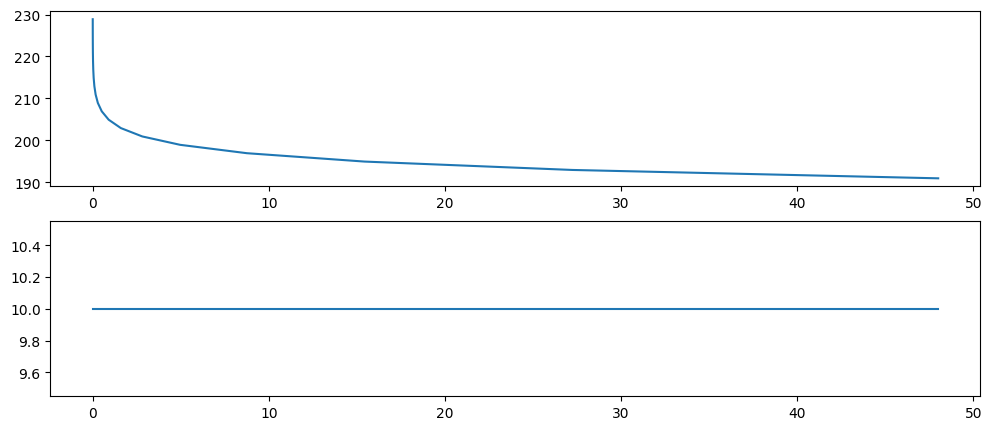

In [16]:
q = 10
t_list = np.logspace(np.log10(0.001), np.log10(48), 20)
q_list = np.full_like(t_list, q)
td_list = wf.td_from_t(t_list)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5))
ax1.plot(t_list, wf.p_from_pd_atma(wf.pd_line_source_ei(td_list, rd=1, qd=q)))
ax2.plot(t_list, q_list)
plt.show()

# Запуск и остановка скважины


Пусть решение задачи запуска скважины (падения давления) будет $p_D(t_D, r_D)$. Тогда решение для изменения давления при запуске и последующей остановки скважины можно представить в виде 
$$p_{bu.D}(t_D, t_{prod.D}, r_D) = p_D(t_D) - p_D(t_D-t_{prod.D}, r_D) \cdot \mathcal{H}(t_D-t_{prod.D})$$

где
* $t_D$ - безразмерное время после запуска скважины,
* $t_{prod.D}$ - безразмерное время работы скважины после запуска
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0) (в некоторых книгах обозначается как $\theta$)
* $p_D(t_D, r_D)$ - безразмерное давление - решение задачи запуска скважины (падения давления)
* $p_{bu.D}(t_D, t_{prod.D}, r_D)$ - безразмерное давление- решение задачи запуска скважины и последующей остановки скважины

Для проведения векторных расчетов в python удобно выражение с использованием функции Хевисайда

$$ \mathcal{H} = \begin{cases}0 & x < 0\\1 & x = 0\\1 & x > 0\end{cases}$$

Применение функции Хевисайда позволяет избежать в расчетных функциях применение условных операторов в явном виде для отдельных элементов входных массивов. Это потенциально ускоряет расчет. 

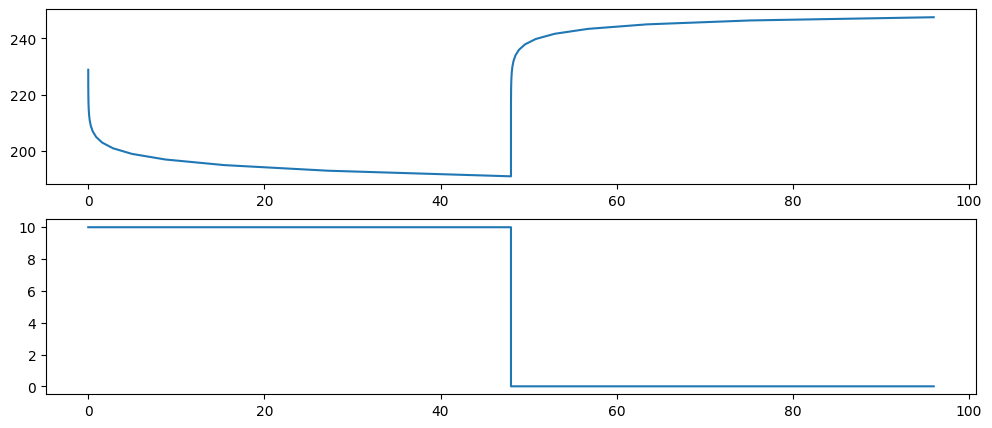

In [17]:
q = 10
t_p_hr = 48

t_list = np.logspace(np.log10(0.001), np.log10(t_p_hr), 20)
t_list_bu = np.concatenate([t_list, t_list + t_p_hr])

q_list = np.concatenate([np.full_like(t_list, q), np.full_like(t_list, 0)])

td_list = wf.td_from_t(t_list_bu)
td_p = wf.td_from_t(t_p_hr)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5))
ax1.plot(t_list_bu, wf.p_from_pd_atma(wf.pd_line_source_ei_build_up(td_list, td_p, rd=1, qd=q)))
ax2.plot(t_list_bu, q_list)

# Множественные запуски и остановки

Используя принцип суперпозиции, можем выписать выражение для изменения давления на скважине и вокруг нее для произвольного момента времени

$$p_{mr.D}(t_D, r_D) = \sum_i \left[ q_{D(i)}-q_{D(i-1)} \right] \cdot p_D\left(t_D-t_{D(i)}, r_D\right)\cdot \mathcal{H}(t_D-t_{D(i)})  $$

где

* $i$ - индекс значения дебита в таблице изменения дебитов
* $q_{D(i)}$ - безразмерный дебит с номером $i$, который стартует в момент времени $t_i$. Для первого момента времени $i$ дебит следующий перед ним считается равным нулю
* $t_{D(i)}$ - безразмерный момент времени - включения дебита с номером $i$
* $t_{D}$ - безразмерный момент времени для которого проводится расчет
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0#:~:text=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F%20%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0%20%D1%88%D0%B8%D1%80%D0%BE%D0%BA%D0%BE%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D1%83%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2,%D0%B4%D0%BB%D1%8F%20%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%B8%20%D1%8D%D0%BC%D0%BF%D0%B8%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9%20%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8%20%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F.)
* $p_D\left(t\right)$ - зависимость безразмерного давление от времени - решение задачи запуска скважины с постоянным единичным дебитом
* $p_{mr.D} $ - безразмерное давление $P_{mr.D}(t_D, r_D)$ учитывающее историю изменения дебитов скважины

In [18]:
# создадим историю изменения дебитов 

t_history = np.array([ 0., 2., 24. ], dtype=np.float64) 
q_history = np.array([10., 5., 0.], dtype=np.float64)

# массивы должны быть одной и той же длины

In [19]:
def pd_superposition(td, td_hist, qd_hist, rd):
    """
    расчет безразмерного давления для последовательности безразмерных дебитов
    td -  время расчета после запуска, безразмерное
    td_hist - массив времен изменения режимов работы скважин, безразмерное
    qd_hist - массив дебитов установленных после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qdh = np.hstack([0, qd_hist])
    tdh = np.hstack([0, td_hist])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_qd = np.hstack([0, np.diff(qdh)])
    # референсный безразмерный дебит это 1
    
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    # используем куммулятивную сумму numpy для того что суммировать результаты
    dpd = np.cumsum(qd_v * wf.pd_line_source_ei((td_v - tdh), rd) * np.heaviside((td_v - tdh), 1),1 )
    # последний столбец - полная сумма, которая нужна в качестве результата
    return dpd[:,-1]


def q_superposition(t, t_hist, q_hist):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    def interpolate_constant(x, xp, yp):
        indices = np.searchsorted(xp, x, side='right')
        y = np.concatenate(([0], yp))
        return y[indices]

    q=[]
    for ti in t:
        q.append(interpolate_constant(ti, t_hist, q_hist))
    return q

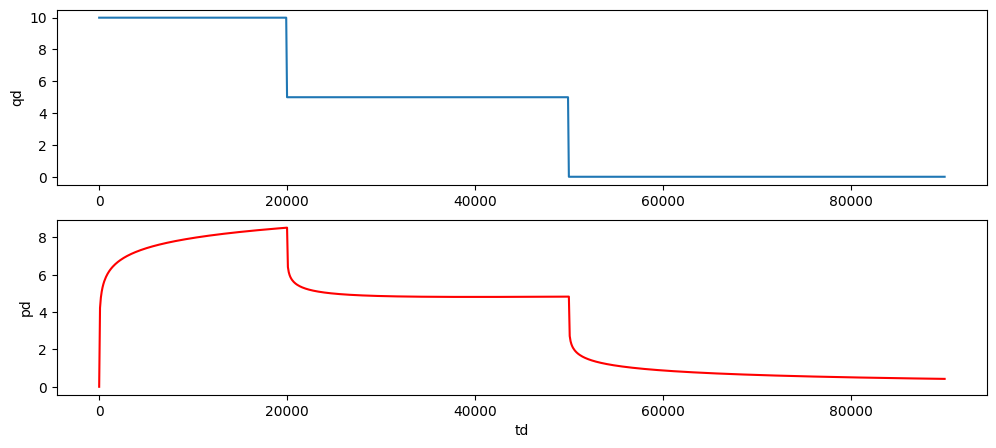

In [20]:
td_arr = np.linspace(1e-3, 9e4, 1000)


td_history = np.array([ 0., 2e4, 5e4 ], dtype=np.float64) 
qd_history = np.array([10., 5., 0.], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, pd_superposition(td_arr, td_history, qd_history, rd=1), color='red') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()

# Интергал Дюамеля


Решение для произвольной истории изменения дебита, выраженной в виде гладкой функции $q_D(t_D)$ можно выразить в виде интеграла 

$$
p_D(t_D) = q_D(0) p_D(t_D) + \int_0^{t_D} \frac{dq_D(\tau)}{d\tau} p_D(t_D- \tau) d\tau
$$

где

- $t_D$ - безразмерное время для которого проводится расчет
- $p_D(t_D)$ - решение задачи для запуска скважины с единичным дебитом $q_D=1$
- $\tau$ - переменная интегрирования

In [ ]:
# используем функцию интегрирования из scipy
from scipy.integrate import quad

# генератор производной для произвольной функции f(x)
def make_diff(f):
    def diff(x, dx=0.01):
        return (f(x+dx) - f(x-dx)) / 2 / dx
    return diff

In [33]:
def pd_super(td, fqd, rd=1):
    dfqd = make_diff(fqd)
    def integrand(tau):
        return dfqd(tau) * wf.pd_line_source_ei(td-tau, rd=rd, qd=1) 
    return quad(integrand, 0, td)[0]

In [38]:
def pd_super_vectorized(td, fqd, rd=1):
    dfqd = make_diff(fqd)
    
    def single_calculation(td_val):
        def integrand(tau):
            return dfqd(tau) * wf.pd_line_source_ei(td_val - tau, rd=rd, qd=1)
        return quad(integrand, 0, td_val)[0]
    
    vectorized_func = np.vectorize(single_calculation)
    return vectorized_func(td)

In [63]:
def piecewise_func(x):

    def f1(x): return x/1000      # x < 0
    def f2(x): return 10         # 0 <= x < 1  
    def f3(x): return 10      # x >= 1
    
    conditions = [
        x < 10000,           # condition for f1
        (x >= 10000) & (x < 50000),  # condition for f2
        x >= 50000           # condition for f3
    ]
    
    functions = [f1, f2, f3]
    
    return np.piecewise(x, conditions, functions)


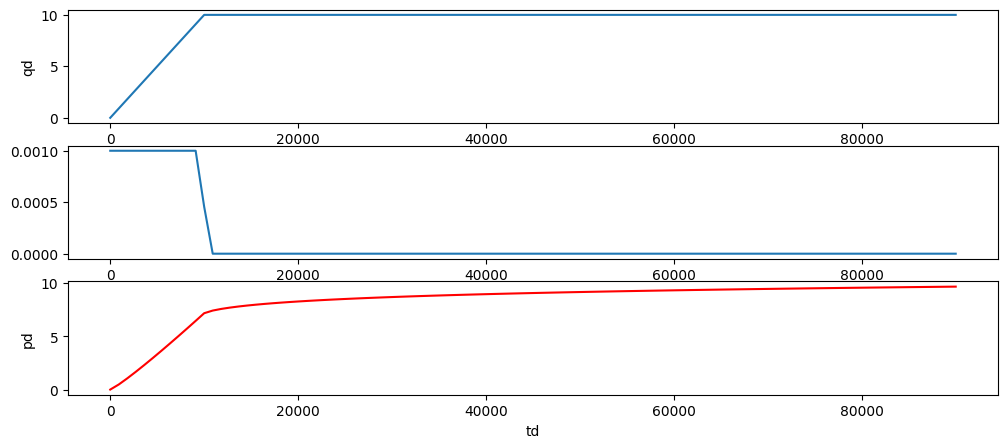

In [65]:
td_arr = np.linspace(1e-3, 9e4, 100)


plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

def fq(td):
    return piecewise_func(td) # (np.sin(td/4000) ) * 10
dfq = make_diff(fq)

ax1.plot(td_arr, fq(td_arr) ) 
ax2.plot(td_arr, dfq(td_arr) )
ax3.plot(td_arr, pd_super_vectorized(td_arr, fq), color='red') 
ax3.set_xlabel('td')
ax1.set_ylabel('qd')
ax3.set_ylabel('pd')
plt.show()

In [37]:
pd_super(np.array([10, 100]), fq)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

проверим, как работет производная, что с этим можно сделать?

In [60]:
wf.pd_line_source_ei(10, 1)

np.float64(0.24959540821048085)

In [22]:
def f(x):
    return np.sin(x)

In [23]:
df = make_diff(f)

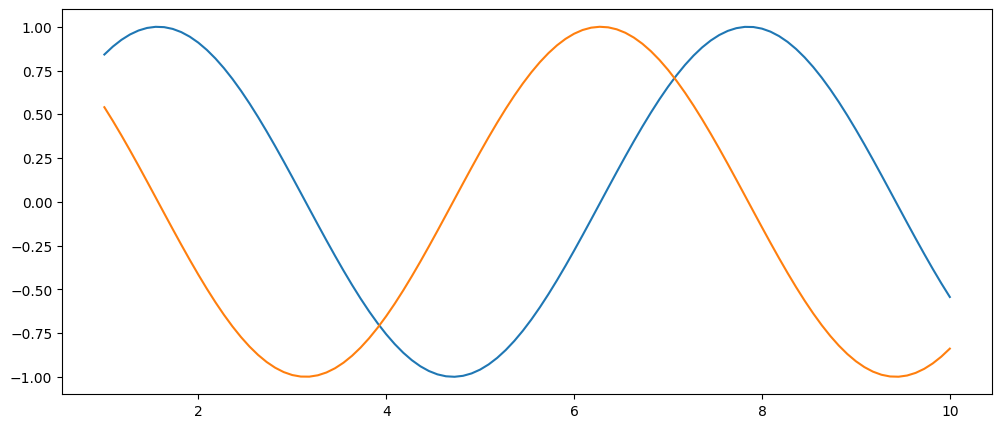

In [24]:
x = np.linspace(1, 10, 100)

plt.plot(x, f(x))
plt.plot(x, df(x))